## Infinite Impulse Response (IIR) Filters (Remixed)

In [51]:
import numpy as np
import scipy.signal as signal

In [52]:
def sample_poles(filter_order):
    """
    Systems represented by stable right-sided sequences have all poles located within the unit circle, which suggests all eigenvalues of the system have magnitude less than one and thus state variables decay over time.
    """
    centerX = centerY = 0
    R = 1
    z = [0] * filter_order
    p = []
    for _ in range(filter_order // 2):
        r = R * np.sqrt(np.random.rand())
        theta = np.random.rand() * 2 * np.pi
        x = centerX + r * np.cos(theta)
        y = centerY + r * np.sin(theta)
        t = x + y * 1j

        p.append(t)
        p.append(t.conjugate())

    if filter_order%2 == 1:
        p.append(np.random.rand())
    return z, p

# Set Parameters
filter_order = N = 5
hidden_size = 10

seq_len = 150
wash_out = 50
batch_size = 100
split_ratio = 0.8

# Generate Data
z, p = sample_poles(filter_order)
b, a = signal.zpk2tf(z, p, 1)

## Visualize the Response
### Impulse Response

In [53]:
import matplotlib.pyplot as plt
from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

In [54]:
def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis="x", direction="in")
    ax.tick_params(axis="y", direction="in")

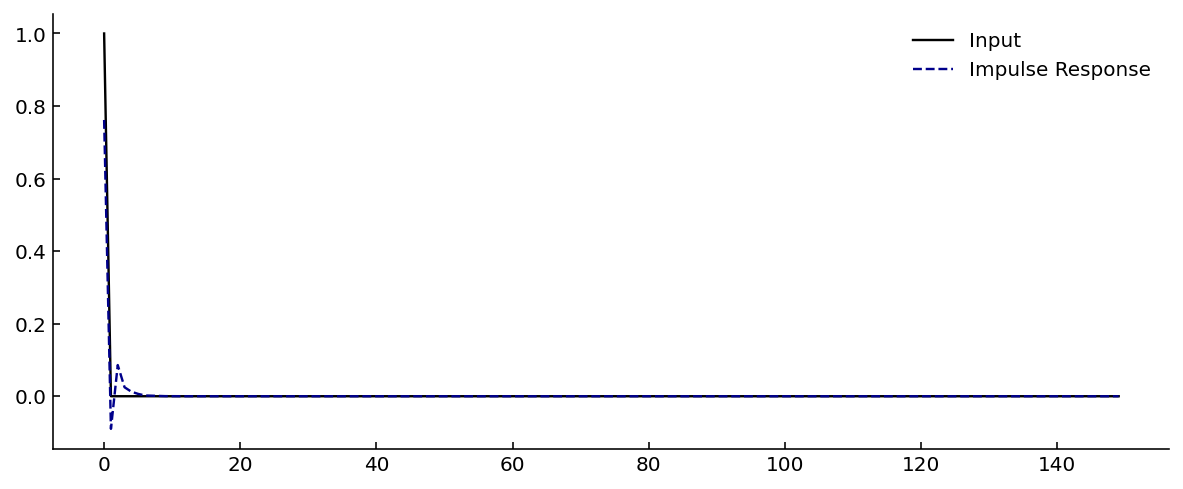

In [55]:
input = signal.unit_impulse(seq_len)
output = np.tanh(signal.lfilter(b, a, input))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
stylize_axes(ax)
ax.plot(input, label="Input", color="black", linewidth=1.2)
ax.plot(output, label="Impulse Response", color="darkblue", linestyle="--", linewidth=1.2)
ax.legend(loc="upper right", frameon=False)
plt.show()

### Gaussian Noise

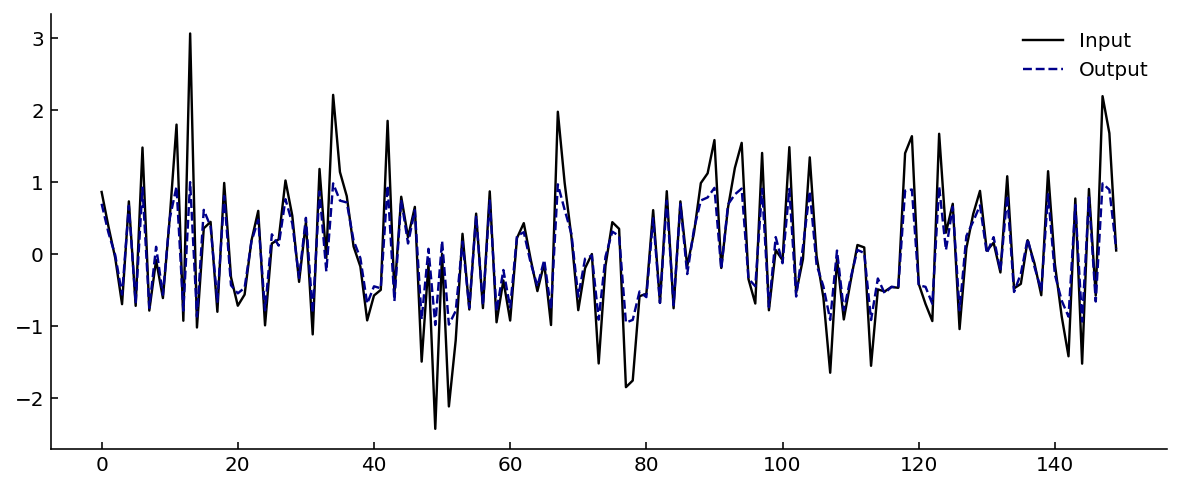

In [56]:
input = np.random.normal(0, 1, size=seq_len)
output = np.tanh(signal.lfilter(b, a, input))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
stylize_axes(ax)
ax.plot(input, label="Input", color="black", linewidth=1.2)
ax.plot(output, label="Output", color="darkblue", linestyle="--", linewidth=1.2)
ax.legend(loc="upper right", frameon=False)
plt.show()

## Define Recurrent Neural Network Model


In [57]:
import torch
from torch import nn

class RNNLayer(nn.Module):
    """Linear RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
                if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.tanh(self.i2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        self.rnn = RNNLayer(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

In [58]:
import math
import cmath
import matplotlib.pyplot as plt

def polar_plot(real_poles, imag_poles, realW_filter, imagW_filter, realW_bptt, imagW_bptt):
    fig = plt.figure(figsize=(15,15))

    theta, r = [], []
    for i,j in zip(real_poles, imag_poles):
        if not math.isnan(i) and not math.isnan(i):
            r_c, theta_c = cmath.polar(complex(i, j))
            r.append(r_c)
            theta.append(theta_c)
    
    r_filter, theta_filter = [], []
    for i,j in zip(realW_filter, imagW_filter):
        if not math.isnan(i) and not math.isnan(i):
            r_c, theta_c = cmath.polar(complex(i, j))
            r_filter.append(r_c)
            theta_filter.append(theta_c)

    r_bptt, theta_bptt = [], []
    for i,j in zip(realW_bptt, imagW_bptt):
        if not math.isnan(i) and not math.isnan(i):
            r_c, theta_c = cmath.polar(complex(i, j))
            r_bptt.append(r_c)
            theta_bptt.append(theta_c)

    ax = fig.add_subplot(121, projection='polar')
    ax.scatter(theta, r, color='black', marker='x', label='Poles')
    ax.scatter(theta_filter, r_filter, color='darkblue', marker='.', label='Filter Eigenvalues')
    ax.scatter(theta_bptt, r_bptt, color='tomato', marker='.', label='RNN Eigenvalues')
    # ax.set_rmax(1)
    # ax.set_rticks([0.25, 0.5, 0.75, 1])    # Less radial ticks
    # ax.set_rlabel_position(-22.5)          # Move radial labels away from plotted line
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.2, -0.05), loc="center right", frameon=False)
    plt.show()  

In [59]:
from matplotlib.animation import FuncAnimation

def return_polar_form(real, imag):
    r, theta = [], []
    for i,j in zip(real,imag):
        r_c, theta_c = cmath.polar(complex(i, j))
        r.append(r_c)
        theta.append(theta_c)
    return theta, r

def plot_polar_animation(real_poles, imag_poles, realW_filter, imagW_filter, realW_bptt, imagW_bptt, frames):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='polar')

    sc_poles = ax.scatter(*return_polar_form(real_poles, imag_poles), color='black', marker='x', label='Poles')
    sc_filter = ax.scatter([], [], color='darkblue', marker='.', label='Filter Eigenvalues')
    sc_bptt = ax.scatter([], [], color='tomato', marker='.', label='RNN Eigenvalues')

    # Update the frames based on the parameter i
    def animate(i):
        fig.suptitle(f'Epoch {i}')
        theta_filter, r_filter = return_polar_form(realW_filter[i], imagW_filter[i])
        sc_filter.set_offsets(np.c_[theta_filter, r_filter])

        theta, r = return_polar_form(realW_bptt[i], imagW_bptt[i])
        sc_bptt.set_offsets(np.c_[theta, r])
    
    ax.set_rmax(1)
    ax.set_rticks([0.25, 0.5, 0.75, 1])  # Less radial ticks
    ax.set_rlabel_position(-22.5)        # Move radial labels away from plotted line
    ax.grid(ls='--', lw=0.8)

    ax.legend(bbox_to_anchor=(1.2, -0.05), loc="center right", frameon=False)

    animation = FuncAnimation(fig, animate, interval=200, frames=range(frames))
    animation.save('polar_plot_animation.gif', writer='pillow') 

In [60]:
# Instantiate Model
net = RNNNet(1, N, 1)

# Vector with a "1" for input x
i2h = torch.zeros((N,1))
i2h[0,0] = torch.tensor(1.0)
net.rnn.i2h.weight = nn.Parameter(i2h)

# Shifted diagonal matrix and IIR filter coefficients
a_copy = -a
a_copy[0] = 1
h2h = torch.diag(torch.ones(N-1), diagonal=-1)
h2h[0,:] = torch.from_numpy(a_copy[1:])
net.rnn.h2h.weight = nn.Parameter(h2h)

# Weight for linear output layer to select h[0]
fc = torch.zeros((1,N))
fc[0][0] = torch.tensor(1.0)
net.fc.weight = nn.Parameter(fc) 

In [61]:
# Create input and output of shape (batch_size x seq_len x input_dims) 
def create_dataset(batch_size, seq_len):
    X = np.random.normal(0, 1, size=(seq_len, batch_size, 1))
    X = torch.from_numpy(X).type(torch.float)
    Y, _ = net(X)
    return X, Y

X, Y = create_dataset(batch_size, seq_len)

split_index = int(split_ratio*batch_size)
train_X, train_Y = X[:,:split_index,:], Y[:,:split_index,:]
test_X, test_Y = X[:,split_index:,:], Y[:,split_index:,:]

## Train the RNN

In [62]:
from torch.autograd import Variable

net_trained = RNNNet(1, hidden_size, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net_trained.parameters(), lr=0.01)

loss_train = []
epochs = 5000
for epoch in range(epochs):
    # Zero the gradient buffer
    optimizer.zero_grad()
    
    # Forward pass
    train_inp = Variable(train_X)
    train_out = Variable(train_Y)
    pred, _ = net_trained(train_inp)

    # Measure the loss
    loss = criterion(pred[:,wash_out:,:], train_out[:,wash_out:,:])
    loss_train.append(loss.data.item())

    # Print the loss
    if epoch%50==0:
        print(epoch, loss.data.item())

    # Backward pass
    loss.backward()
    optimizer.step()

0 0.39275839924812317
50 0.005092037841677666
100 0.001713958801701665
150 0.0006103457417339087
200 0.00021799610112793744
250 0.00011764337978092954
300 9.121331822825596e-05
350 7.85754673415795e-05
400 6.923096952959895e-05
450 6.126752123236656e-05
500 5.4194126278162e-05
550 4.785543933394365e-05
600 4.217571404296905e-05
650 3.709916927618906e-05
700 3.2576455851085484e-05
750 2.856184437405318e-05
800 2.5011939214891754e-05
850 2.188544749515131e-05
900 1.914296626637224e-05
950 1.6746873370721005e-05
1000 1.4661743989563547e-05
1050 1.2854228771175258e-05
1100 1.1293253010080662e-05
1150 9.950272215064615e-06
1200 8.799127499514725e-06
1250 7.816069228283595e-06
1300 6.979536465223646e-06
1350 6.270010999287479e-06
1400 5.669903657690156e-06
1450 5.163370587979443e-06
1500 4.736307801067596e-06
1550 4.376207925815834e-06
1600 4.072103820362827e-06
1650 3.814541742030997e-06
1700 3.595426278479863e-06
1750 3.4079369015671546e-06
1800 3.246405867685098e-06
1850 3.106159283561283

In [63]:
def plot_loss_history(loss_train, loss_test, loss_optimal):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    ax.loglog(loss_train, color='darkblue', label ="BPTT Train", linewidth=1.2)
    ax.loglog(loss_test*np.ones(epochs), color='gray', label ="BPTT Test", linewidth=1.2)
    if loss_optimal is not None:
        ax.loglog(loss_optimal*np.ones(epochs), color='green', label ="Optimal")
    stylize_axes(ax)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(loc="upper right", frameon=False)
    plt.show()

8.528122e-07


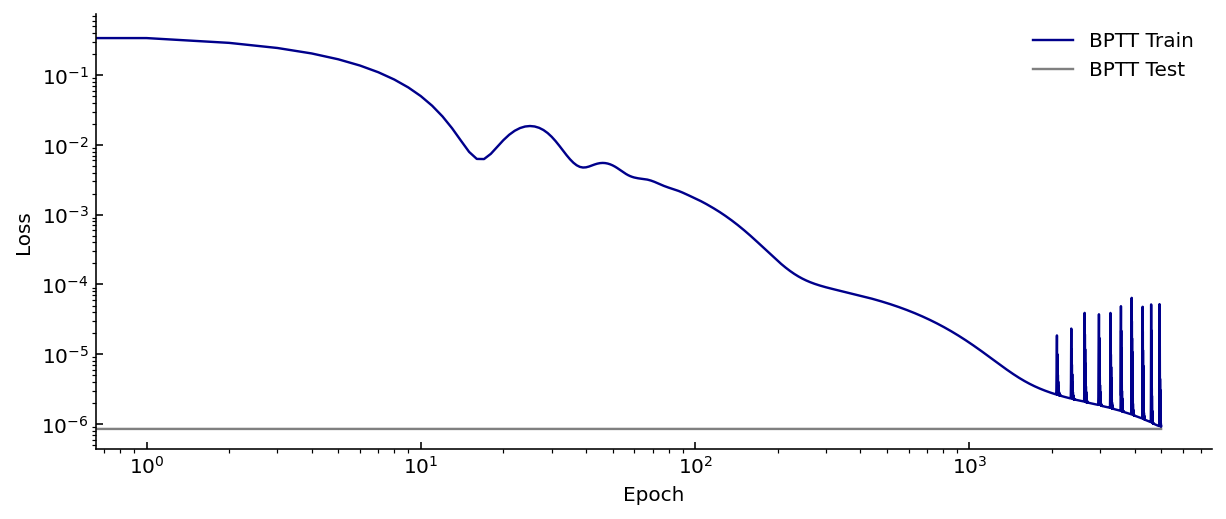

In [64]:
# Predict
pred, rnn_output = net_trained(test_X)

# Compute Loss
loss_test = criterion(pred[wash_out:,:,:], test_Y[wash_out:,:,:]).detach().numpy()
print(loss_test)

plot_loss_history(loss_train, loss_test, None)

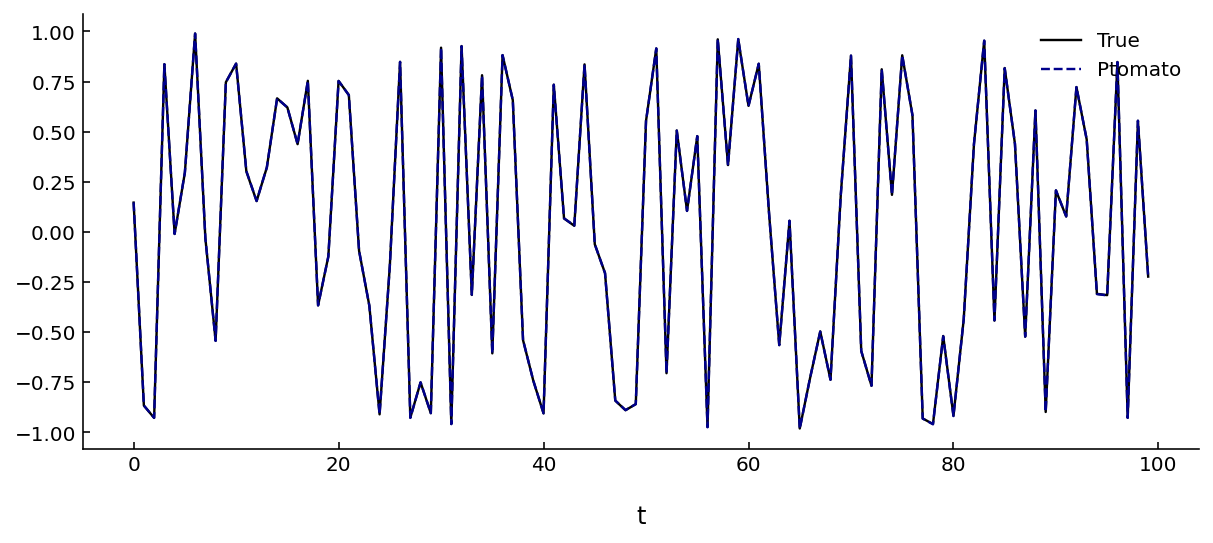

In [65]:
def plot_time_series(true, ptomato):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    stylize_axes(ax)
    ax.plot(true, label="True", linestyle='solid', color='black', linewidth=1.2)
    ax.plot(ptomato, label="Ptomato", linestyle='dashed', color='darkblue', linewidth=1.2)
    ax.set_xlabel("t", fontsize=12, labelpad=15)
    ax.legend(loc="upper right", frameon=False)
    plt.show()

index_to_plot = 0
plot_time_series(test_Y[wash_out:,index_to_plot,0].detach().numpy(), pred[wash_out:,index_to_plot,0].detach().numpy())

## Extract the Lyapunov Exponents

Lyapunov exponent or Lyapunov characteristic exponent of a dynamical system is a quantity that characterizes the rate of separation of infinitesimally close trajectories.

<img src="figures/stability-and-chaos.png" width="700">

Lyapunov spectrum is given by the log of eigenvalues of Oseledets matrix
$$\large
\Lambda = \lim_{t\to\infty} [T_t^T T_t]^{1/2t}
$$

The analytical approximation of which is given by the long-term Jacobian product of non-commuting matrices
$$\large
T_t(h_0) = D_{t-1}(h_{t-1})...D_1(h-1)D_0(h_0)
$$

This is done by unrolling the network dynamics in time
$$\normalsize
\begin{align*}
    \frac{\partial L_t}{\partial W} &= \frac{\partial L_t}{\partial y_t}\frac{\partial y_t}{\partial h_t}\frac{\partial h_t}{\partial W} 
    \\
    &= \frac{\partial L_t}{\partial y_t}\frac{\partial y_t}{\partial h_t}
    \bigg[
        \frac{\partial^+ h_t}{\partial W} + \frac{\partial h_t}{\partial h_{t-1}}\frac{\partial^+h_{t-1}}{\partial W} + ... T_{t-1}(t)\frac{\partial^+ h_1}{\partial W}
    \bigg]
    \\
   T_t(t) &= \frac{\partial h_t}{\partial h_{t-1}}\frac{\partial h_{t-1}}{\partial h_{t-2}}...\frac{\partial h_{t-\tau+1}}{\partial h_{t-\tau}}
\end{align*}
$$

The RNN update equation is given by,

$$\large
h_t=tanh(W_{ih}\cdot  x_t+b_{ih}+W_{hh}\cdot h_{t−1}+b_{hh})$$

where the Jacobian is given by,

$$\normalsize
\begin{align*}
\frac{\partial h_{t+1,i}}{\partial h_{t,j}} &= w_{i,j} (1-tanh^2(h_{t+1,i})) \\
\frac{\partial h_{t+1}}{\partial h_t} &= W_{hh} diag(1-tanh^2(h_{t+1}))
\end{align*}
$$

Since pre-multiplying a matrix $A$ by a diagonal matrix $diag(k)$ is equivalent to scaling up row $i$ of matrix $A$ by $k$

In [66]:
def spectral_normalization(W, threshold=0.9):
    eigen_values = torch.linalg.eigvals(W)
    spectral_radius = max(abs(eigen_values))
    if spectral_radius > threshold:
        W = W/max(abs(eigen_values))
    return W

def jacobian(network, x, rnn_state):
    """Compute the Jacobian of an RNN state vector h(t+1) with respect to h(t) for each t."""
    jac_stacked = []
    hidden = rnn_state[-1]
    feed_seq = x.shape[0]
    
    for t in range(feed_seq):
        hidden = network.rnn.recurrence(x[t], hidden)
        W_hh = network.rnn.h2h.weight
        W_diag = torch.diag(1-torch.tanh(torch.pow(torch.flatten(hidden),2)))

        jac_t = torch.matmul(W_hh, W_diag)  # [N, N]
        jac_stacked.append(jac_t)

    # Stack together output from all time steps
    return torch.stack(jac_stacked)

In [67]:
feed_seq = 100
sample_id = 0

# Long-term Jacobian for the filter coefficients
_, rnn_state = net(test_X[0:wash_out,sample_id:sample_id+1,:])
jac_stacked_filter = jacobian(net, test_X[wash_out:wash_out+feed_seq,sample_id:sample_id+1,:], rnn_state)

# Long-term Jacobian for the bptt-rnn
_, rnn_state = net_trained(test_X[0:wash_out,sample_id:sample_id+1,:])
jac_stacked_bptt = jacobian(net_trained, test_X[wash_out:wash_out+feed_seq,sample_id:sample_id+1,:], rnn_state)

In [68]:
from scipy import linalg

def extract_eigen_values(M):
    eW = np.linalg.eigvals(M)
    rea = [n.real for n in eW]
    imag = [n.imag for n in eW]
    return rea, imag

def log(x):
	return np.array([cmath.log(xx) for xx in x])

def extract_lyapunov_exponents(jac_stacked, feed_seq, mode='LOG'):
    if mode == 'LOGARITHMIC':
        jac_cumulative = linalg.expm(sum([linalg.logm(jac_t.detach().numpy(), False)[0] for jac_t in jac_stacked])/feed_seq)
        return extract_eigen_values(jac_cumulative)

    if mode == 'CUMULATIVE':
        jac_cumulative = jac_stacked[0].detach().numpy()
        for jac_t in jac_stacked[1:]:
            jac_t = jac_t.detach().numpy()
            jac_cumulative = np.matmul(jac_cumulative, jac_t)
        return extract_eigen_values(jac_cumulative)

    if mode == 'FRACTIONAL_ROOT':
        jac_cumulative = jac_stacked[0].detach().numpy()
        for jac_t in jac_stacked[1:]:
            jac_t = jac_t.detach().numpy()
            jac_cumulative = np.matmul(jac_cumulative, jac_t)
        return extract_eigen_values(linalg.fractional_matrix_power(jac_cumulative, 1./feed_seq))
        
    # Calculate the spectrum of Lyapunov exponents by applying a QR-decomposition on the parallelepiped matrix N times. Return the spectrum sorted from maximum to minimum.
    if mode == 'QR_DECOMPOSITION':
        rvals = np.zeros((feed_seq, jac_stacked[0].shape[0]), dtype=np.complex128)
        jac_cumulative = jac_stacked[0].detach().numpy()
        # jac_cumulative = np.eye(jac_stacked[0].shape[0])
        lyapunov_exponents = np.zeros(jac_stacked[0].shape[0], dtype=np.complex128)
        for t in range(1,feed_seq):
            jac_t = jac_stacked[t].detach().numpy()
            jac_cumulative = np.matmul(jac_t, jac_cumulative)
            jac_cumulative, R = linalg.qr(jac_cumulative)
            r = log(np.abs(np.diag(R)))
            lyapunov_exponents += r
            rvals[t,:] = lyapunov_exponents/t
        lyapunov_exponents /= feed_seq
        return lyapunov_exponents, rvals
        
    if mode == 'DISCRETE_LEs':
        return None

In [69]:
W_filter, rvals_filter = extract_lyapunov_exponents(jac_stacked_filter, feed_seq, 'QR_DECOMPOSITION')
W_bptt, rvals_bptt = extract_lyapunov_exponents(jac_stacked_bptt, feed_seq, 'QR_DECOMPOSITION')

## Visualize Lyapunov Exponents

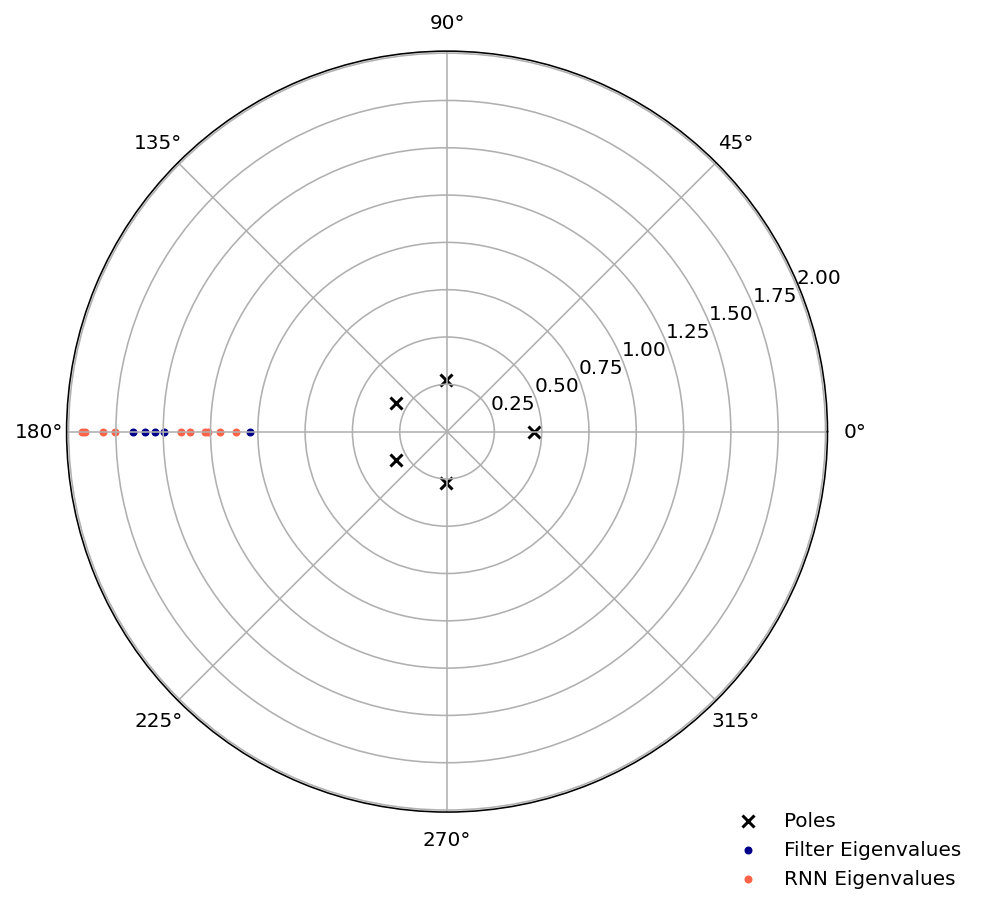

In [70]:
real_poles, imag_poles = [x.real for x in p], [x.imag for x in p]
realW_filter, imagW_filter = [n.real for n in W_filter], [n.imag for n in W_filter]
realW_bptt, imagW_bptt = [n.real for n in W_bptt], [n.imag for n in W_bptt]

polar_plot(real_poles, imag_poles, realW_filter, imagW_filter, realW_bptt, imagW_bptt)

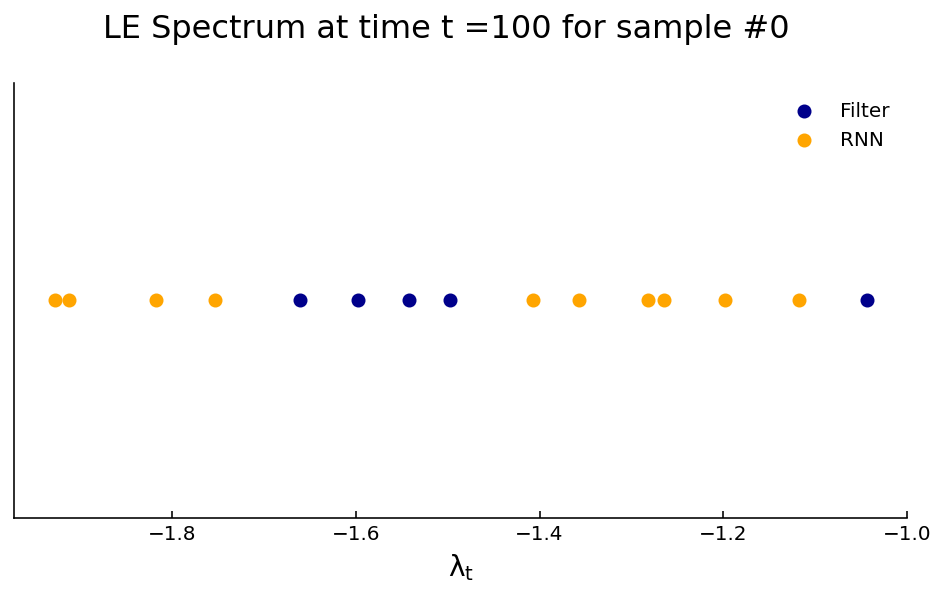

In [71]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
stylize_axes(ax)

ax.set_yticks([])

ax.scatter(realW_filter, np.zeros_like(np.arange(len(realW_filter))), label="Filter", color="darkblue")
ax.scatter(realW_bptt, np.zeros_like(np.arange(len(realW_bptt))), label="RNN", color="orange")

ax.set_xlabel(r'$\lambda_t$', fontsize=14)

ax.legend(loc="upper right", frameon=False)
plt.suptitle('LE Spectrum at time t ='+str(feed_seq)+' for sample #'+ str(sample_id), fontsize=16, y=1)

plt.show()

In [72]:
import warnings
warnings.filterwarnings('ignore')

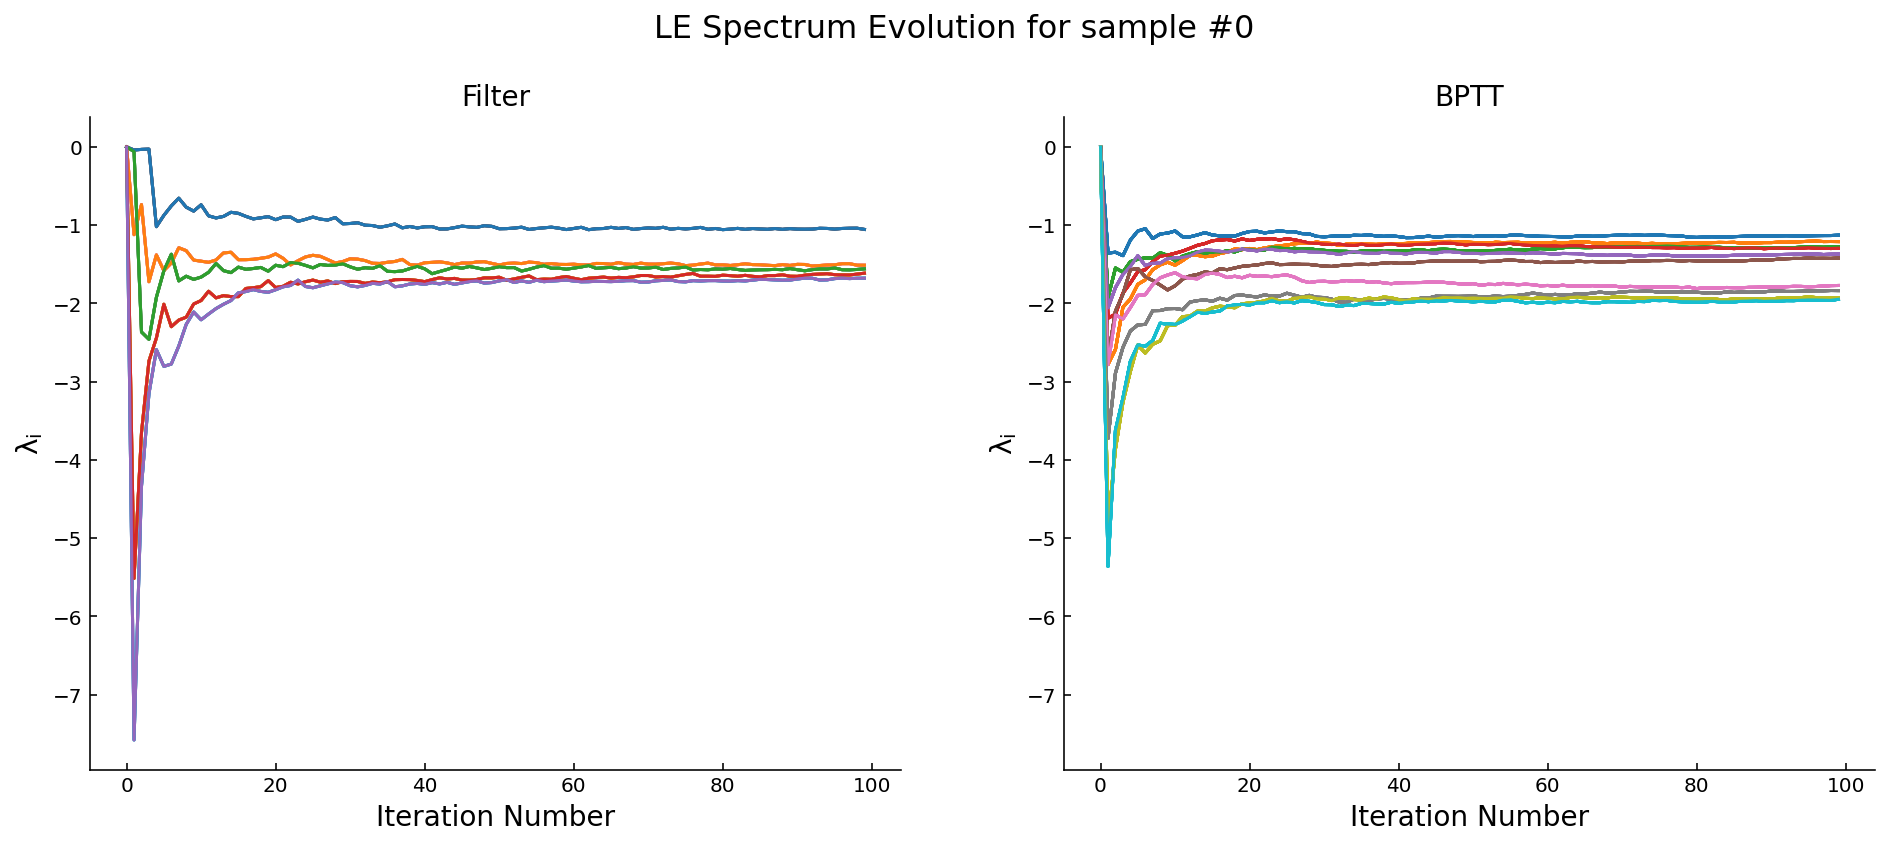

In [73]:
def plot_evolution(rvals_filter, rvals_bptt):
    fig = plt.figure(figsize=(16,6))
    ax1 = fig.add_subplot(121)
    stylize_axes(ax1)
    feed_seq = rvals_filter.shape[0]
    for i in range(rvals_filter.shape[1]):
        ax1.plot(rvals_filter)
        # ax1.plot(np.divide(np.cumsum(rvals_filter[:,i], axis=0), np.arange(1., feed_seq+1)))
    ax1.set_xlabel('Iteration Number', fontsize=14)
    ax1.set_ylabel(r"$\lambda_i$", fontsize=14)
    ax1.set_title('Filter', fontsize=14)

    ax2 = fig.add_subplot(122, sharey=ax1)
    stylize_axes(ax2)
    feed_seq = rvals_bptt.shape[0]
    for i in range(rvals_bptt.shape[1]):
        ax2.plot(rvals_bptt)
        # ax2.plot(np.divide(np.cumsum(rvals_bptt[:,i], axis=0), np.arange(1., feed_seq+1)))
    ax2.set_xlabel('Iteration Number', fontsize=14)
    ax2.set_ylabel(r"$\lambda_i$", fontsize=14)
    ax2.set_title('BPTT', fontsize=14)

    plt.suptitle('LE Spectrum Evolution for sample #'+ str(sample_id), fontsize=16, y=1)
    plt.show()

plot_evolution(rvals_filter, rvals_bptt)

In [74]:
les_filter = np.zeros((test_X.shape[1], W_filter.shape[0]), dtype=np.complex128)
les_bptt = np.zeros((test_X.shape[1], W_bptt.shape[0]), dtype=np.complex128)

rvals_filter_stacked = np.zeros((test_X.shape[1], rvals_filter.shape[0], rvals_filter.shape[1]), dtype=np.complex128)
rvals_bptt_stacked = np.zeros((test_X.shape[1], rvals_bptt.shape[0], rvals_bptt.shape[1]), dtype=np.complex128)

for sample_id in range(test_X.shape[1]):
    # Long-term Jacobian for the filter coefficients
    _, rnn_state = net(test_X[0:wash_out,sample_id:sample_id+1,:])
    jac_stacked_filter = jacobian(net, test_X[wash_out:wash_out+feed_seq,sample_id:sample_id+1,:], rnn_state)
    W_filter, rvals_filter = extract_lyapunov_exponents(jac_stacked_filter, feed_seq, 'QR_DECOMPOSITION')
    les_filter[sample_id,:] = [n.real for n in W_filter]
    rvals_filter_stacked[sample_id,:] = rvals_filter

    # Long-term Jacobian for the bptt-rnn
    _, rnn_state = net_trained(test_X[0:wash_out,sample_id:sample_id+1,:])
    jac_stacked_bptt = jacobian(net_trained, test_X[wash_out:wash_out+feed_seq,sample_id:sample_id+1,:], rnn_state)
    W_bptt, rvals_bptt = extract_lyapunov_exponents(jac_stacked_bptt, feed_seq, 'QR_DECOMPOSITION')
    les_bptt[sample_id,:] = [n.real for n in W_bptt]
    rvals_bptt_stacked[sample_id,:] = rvals_bptt

In [89]:
rvals_bptt_stacked

array([[[ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [-1.35579266+0.j, -2.77955286+0.j, -1.92732337+0.j, ...,
         -3.72693374+0.j, -4.84150979+0.j, -5.36102587+0.j],
        [-1.34624784+0.j, -2.58825622+0.j, -1.54789723+0.j, ...,
         -2.89023247+0.j, -3.8601016 +0.j, -3.62041322+0.j],
        ...,
        [-1.13274129+0.j, -1.20942301+0.j, -1.2827656 +0.j, ...,
         -1.83810153+0.j, -1.934003  +0.j, -1.95810199+0.j],
        [-1.1324555 +0.j, -1.20876268+0.j, -1.27945375+0.j, ...,
         -1.83526042+0.j, -1.93151138+0.j, -1.96030515+0.j],
        [-1.12875031+0.j, -1.20954688+0.j, -1.27677349+0.j, ...,
         -1.83588682+0.j, -1.93211536+0.j, -1.9473064 +0.j]],

       [[ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [-2.14662492+0.j, -2.24122912+0.j, -1.89507997+0.j, ...,
         -2.75702057+0.j, -4.40242614+

In [88]:
import pickle
with open('rvals_bptt_stacked.pkl', 'wb') as f:
    pickle.dump(rvals_bptt_stacked, f)

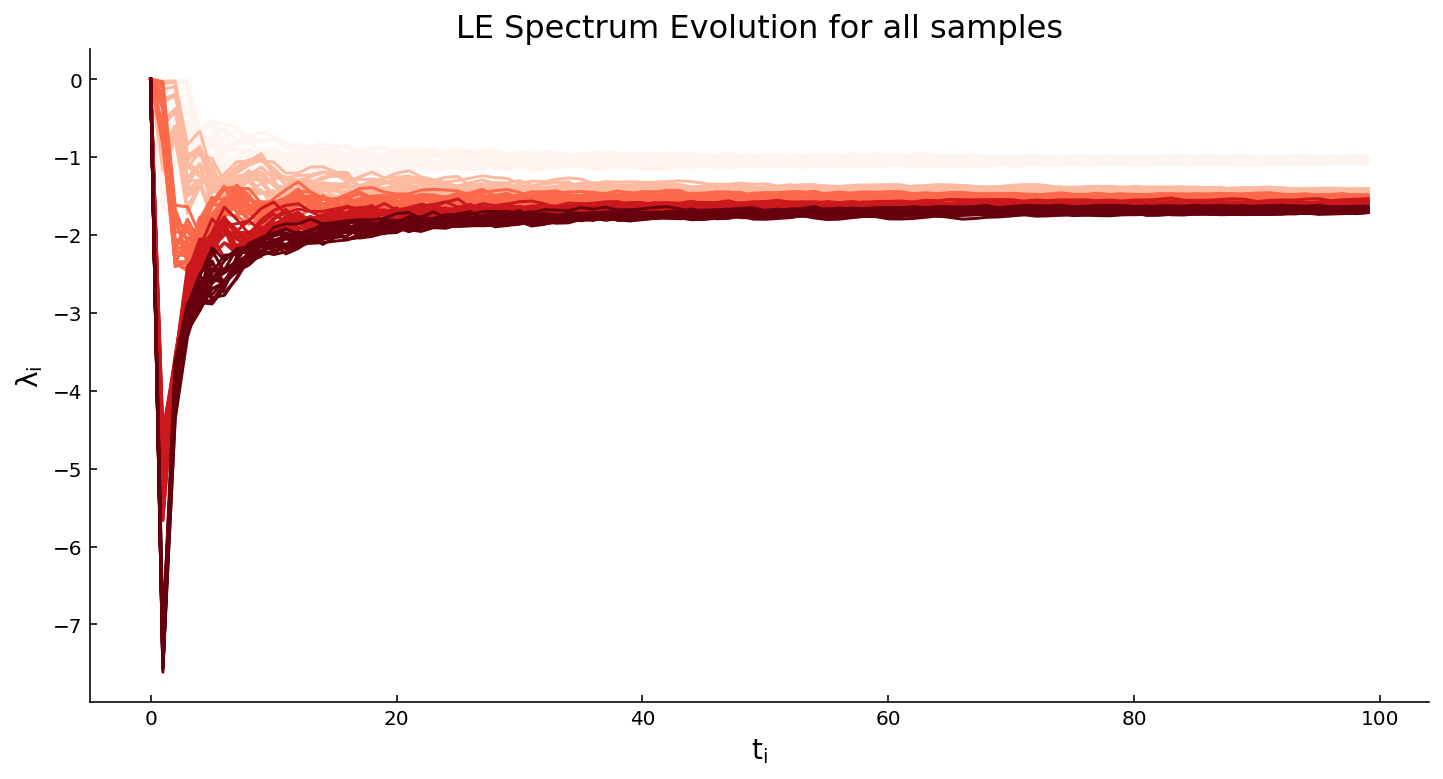

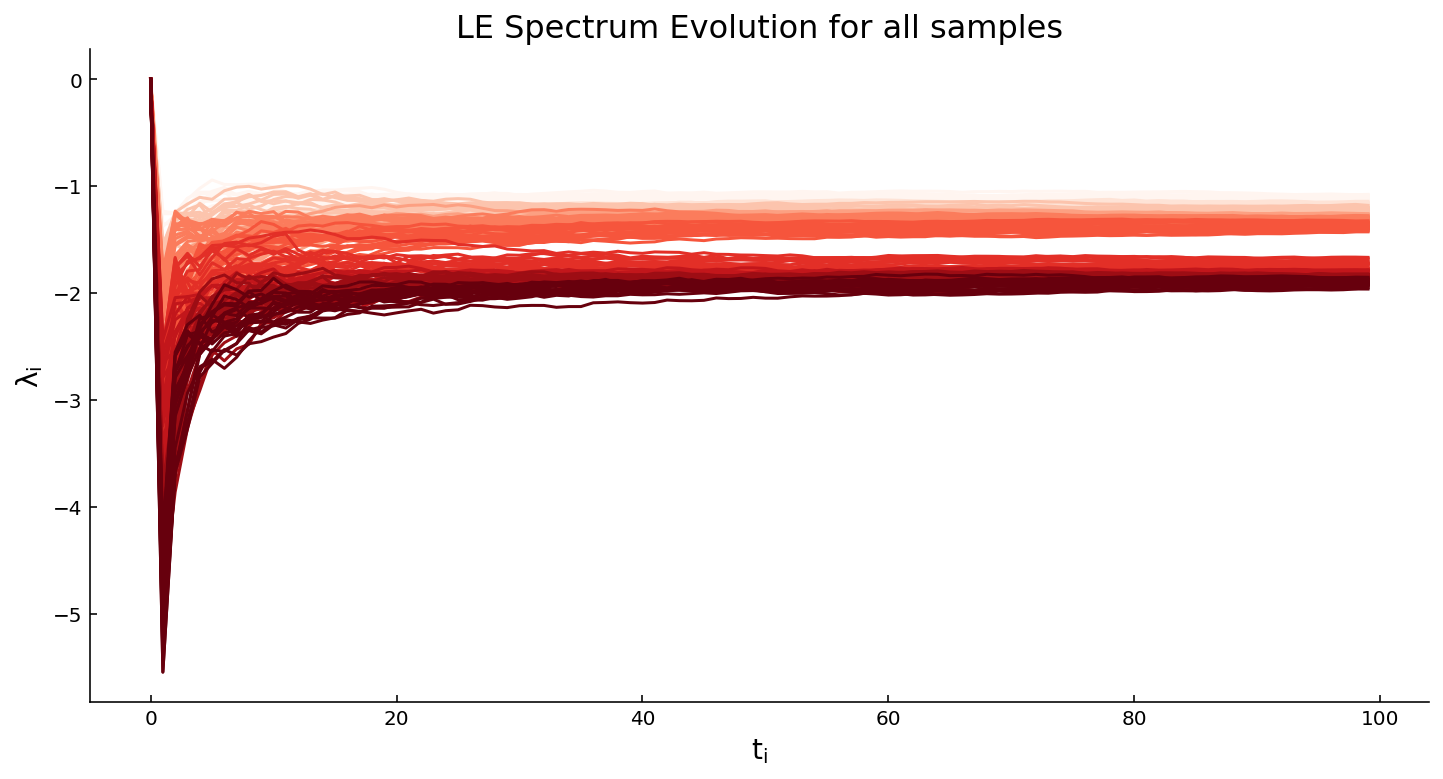

In [86]:
def plot_evolution_all(rvals_stacked):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    stylize_axes(ax)

    color = iter(plt.cm.Reds(np.linspace(0, 1, rvals_stacked.shape[2])))
    for i in range(rvals_stacked.shape[2]):
        c = next(color)
        for j in range(rvals_stacked.shape[0]):
            ax.plot(rvals_stacked[j,:,i], color=c)

    ax.set_xlabel('$t_i$', fontsize=14)
    ax.set_ylabel(r"$\lambda_i$", fontsize=14)

    plt.title('LE Spectrum Evolution for all samples', fontsize=16, y=1)
    plt.show()

plot_evolution_all(rvals_filter_stacked)
plot_evolution_all(rvals_bptt_stacked)

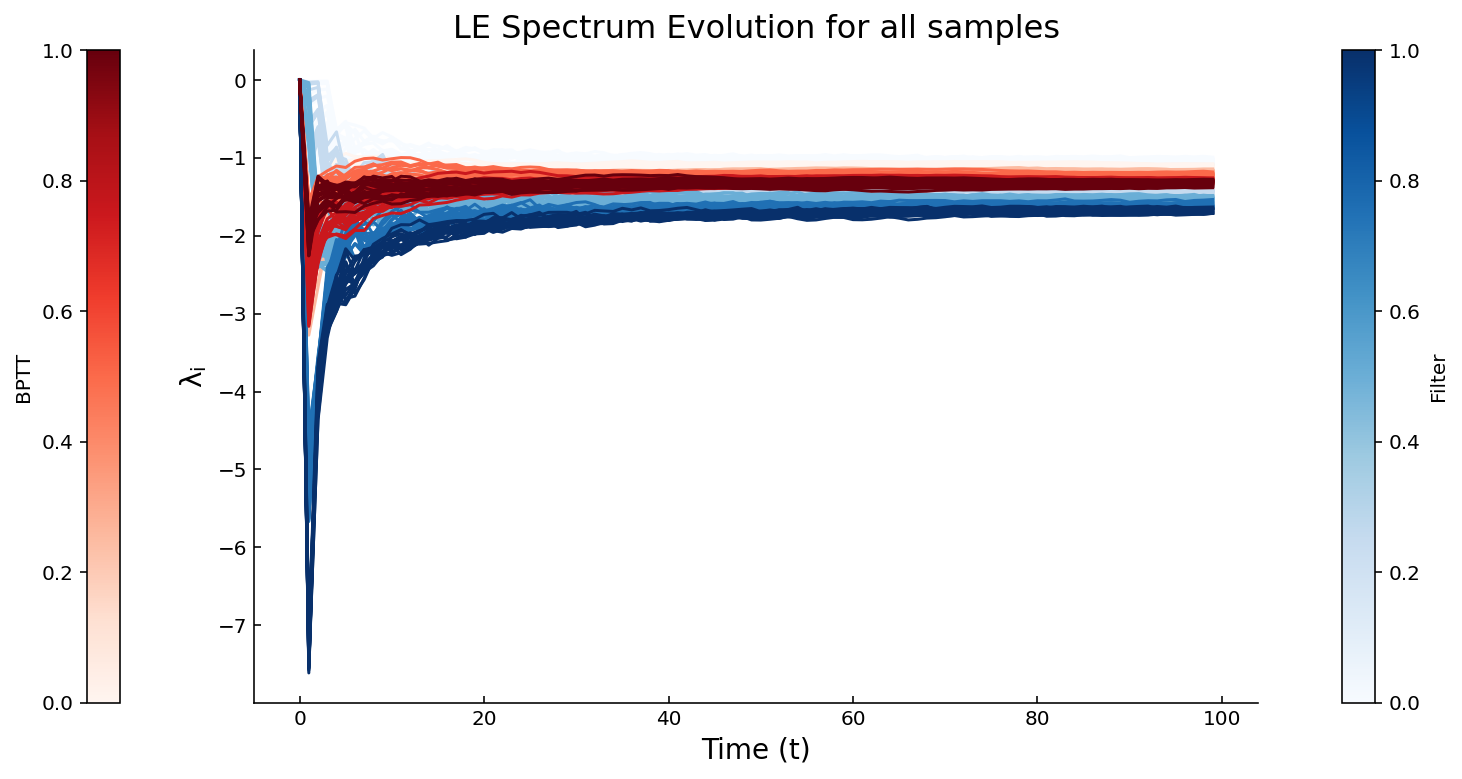

In [76]:
def plot_evolution_all_2(rvals_filter_stacked, rvals_bptt_stacked):
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    stylize_axes(ax)

    color_filter = iter(plt.cm.Blues(np.linspace(0, 1, rvals_filter_stacked.shape[2])))
    color_bptt = iter(plt.cm.Reds(np.linspace(0, 1, rvals_filter_stacked.shape[2])))

    for i in range(rvals_filter_stacked.shape[2]):
        c_filter = next(color_filter)
        for j in range(rvals_filter_stacked.shape[0]):
            ax.plot(rvals_filter_stacked[j,:,i], color=c_filter, label='Filter')

        c_bptt = next(color_bptt)
        for j in range(rvals_bptt_stacked.shape[0]):
            ax.plot(rvals_bptt_stacked[j,:,i], color=c_bptt, label='BPTT')

    ax.set_xlabel('Time (t)', fontsize=14)
    ax.set_ylabel(r"$\lambda_i$", fontsize=14)

    scalarmappaple = plt.cm.ScalarMappable(cmap=plt.cm.Blues)
    plt.colorbar(scalarmappaple, ax=ax, label='Filter')
    scalarmappaple = plt.cm.ScalarMappable(cmap=plt.cm.Reds)
    plt.colorbar(scalarmappaple,location='left',label='BPTT')

    plt.title('LE Spectrum Evolution for all samples', fontsize=16, y=1)
    plt.savefig('filter-success-nonlinear-lyapunov.png', bbox_inches='tight', dpi=600)

plot_evolution_all_2(rvals_filter_stacked, rvals_bptt_stacked)

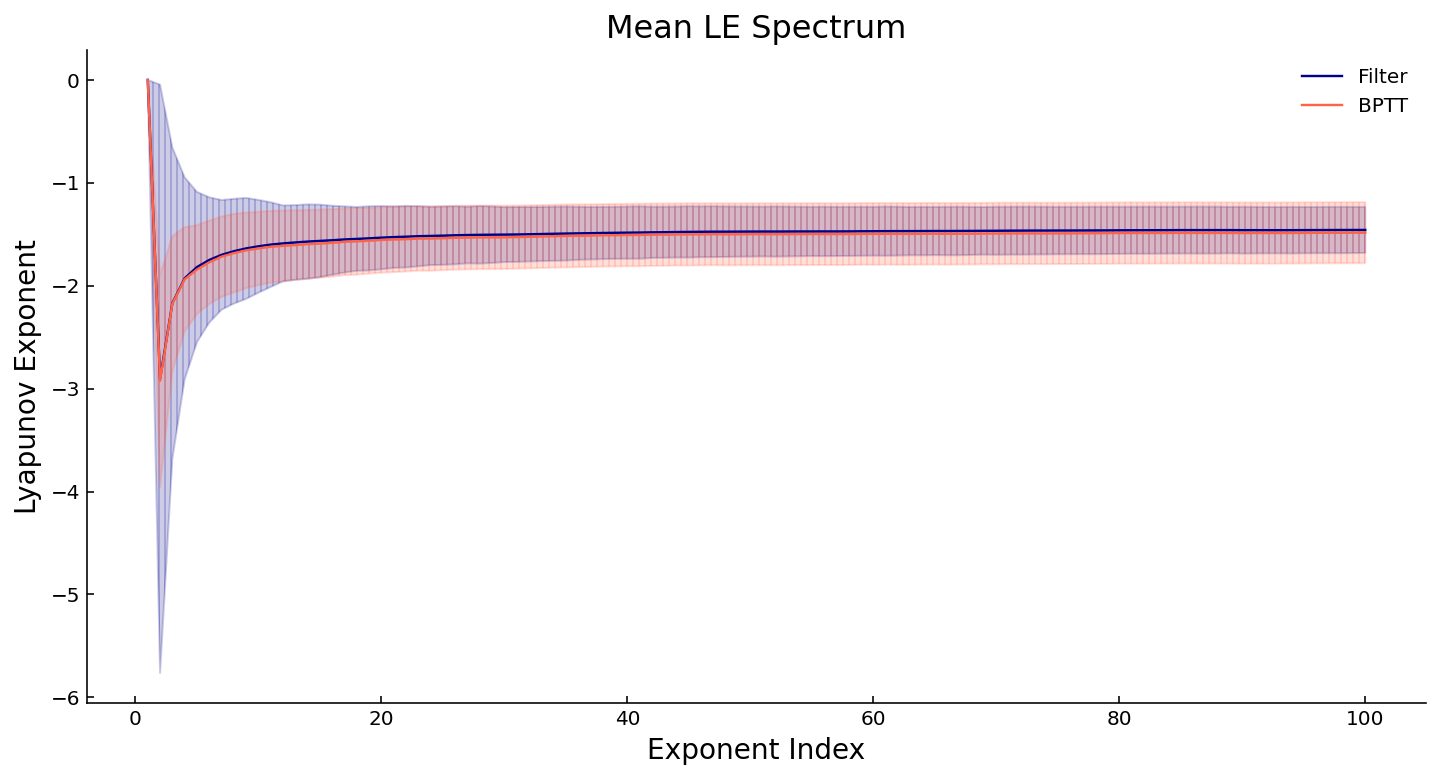

In [77]:
def LE_stats(LE):
    mean, std = (np.mean(LE, axis=(0,2)), np.std(LE, axis=(0,2)))
    return mean, std
    
def plot_spectrum(les_filter, les_bptt):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    stylize_axes(ax)

    feed_seq = les_filter.shape[1]
    x = range(1, feed_seq+1)
    LE_mean, LE_std = LE_stats(les_filter)
    ax.plot(x, LE_mean, color='darkblue', ls='-', lw=1.2, label='Filter')
    ax.fill_between(x, LE_mean-LE_std, LE_mean+LE_std, color='darkblue', alpha=0.2, hatch='||||')

    feed_seq = les_bptt.shape[1]
    x = range(1, feed_seq+1) 
    LE_mean, LE_std = LE_stats(les_bptt)
    ax.plot(x, LE_mean, color='tomato', ls='-', lw=1.2, label='BPTT')
    ax.fill_between(x, LE_mean-LE_std, LE_mean+LE_std, color='tomato', alpha=0.2, hatch='||||')

    ax.set_xlabel('Exponent Index', fontsize=14)
    ax.set_ylabel('Lyapunov Exponent', fontsize=14)
    plt.title('Mean LE Spectrum', fontsize=16)

    ax.legend(frameon=False)
    plt.show()

plot_spectrum(rvals_filter_stacked, rvals_bptt_stacked)

## Visualize the eigenvalue drift cross timesteps

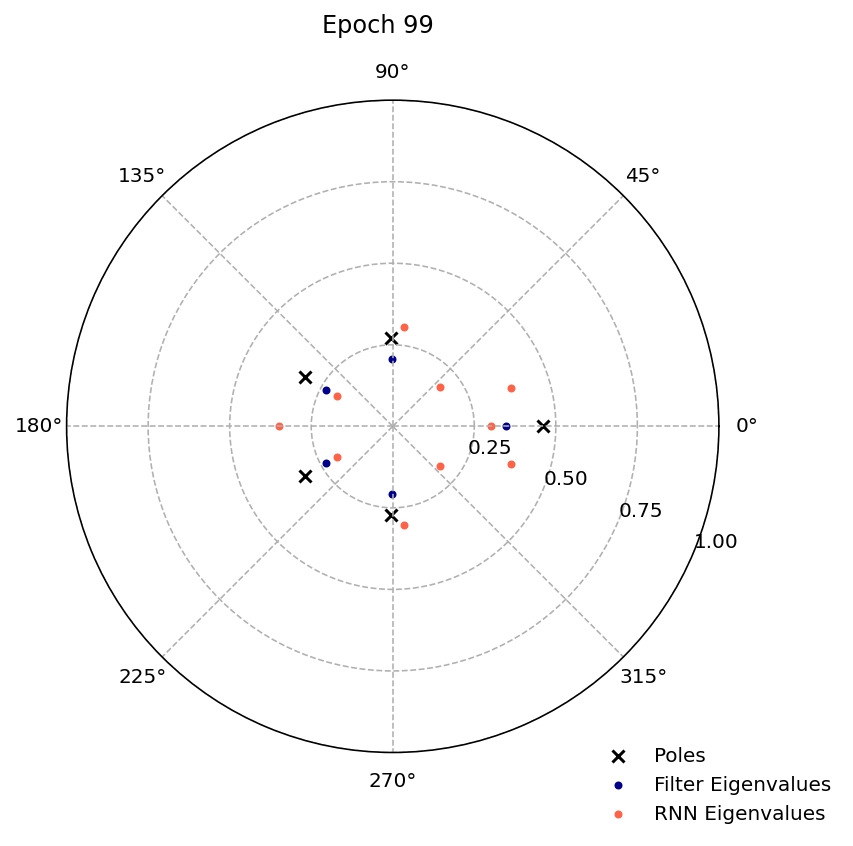

In [78]:
W_filter_stacked = extract_eigen_values(jac_stacked_filter.detach().numpy())
W_bptt_stacked = extract_eigen_values(jac_stacked_bptt.detach().numpy())

plot_polar_animation(real_poles, imag_poles, W_filter_stacked[0], W_filter_stacked[1], W_bptt_stacked[0], W_bptt_stacked[1], feed_seq)

## Compute Similarity Metric

In [79]:
import sys

def findClosestPair(real_pole, imag_pole, W_bptt_set):
    min_euclidean_dist = sys.maxsize
    a = np.array((real_pole ,imag_pole))
    for pair in W_bptt_set:
        b = np.array((pair[0], pair[1]))
        euclidean_dist = np.linalg.norm(a-b)
        if euclidean_dist < min_euclidean_dist:
            min_euclidean_dist = euclidean_dist
            closest_pair = pair
    return min_euclidean_dist, closest_pair

def compute_similarity(threshold, real_poles, imag_poles, realW_bptt, imagW_bptt):
    count = 0
    W_bptt_set = [[realW_bptt[i], imagW_bptt[i]] for i in range(len(realW_bptt))]
    for real_pole, imag_pole in zip(real_poles, imag_poles):
        min_euclidean_dist, closest_pair = findClosestPair(real_pole, imag_pole, W_bptt_set)
        if min_euclidean_dist <= threshold:
            count += 1
        W_bptt_set.remove(closest_pair)
    return count

def compute_similarity_t(W_filter_stacked, W_bptt_stacked, seq_len, threshold=0.2):
    count_stacked = []
    euclidean_dist_stacked = []
    for i in range(seq_len):
        count = 0
        euclidean_dist = 0
        W_bptt_r = W_bptt_stacked[0][i]
        W_bptt_i = W_bptt_stacked[1][i]
        W_bptt_set = [[W_bptt_r[j], W_bptt_i[j]] for j in range(len(W_bptt_r))]
        for real_pole, imag_pole in zip(W_filter_stacked[0][i], W_filter_stacked[1][i]):
            min_euclidean_dist, closest_pair = findClosestPair(real_pole, imag_pole, W_bptt_set)
            euclidean_dist += min_euclidean_dist
            if min_euclidean_dist <= threshold:
                count += 1
            W_bptt_set.remove(closest_pair)
        count_stacked.append(count)
        euclidean_dist_stacked.append(euclidean_dist/N)
    return count_stacked, euclidean_dist_stacked

In [80]:
count_stacked, euclidean_dist_stacked = compute_similarity_t(W_filter_stacked, W_bptt_stacked, feed_seq)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


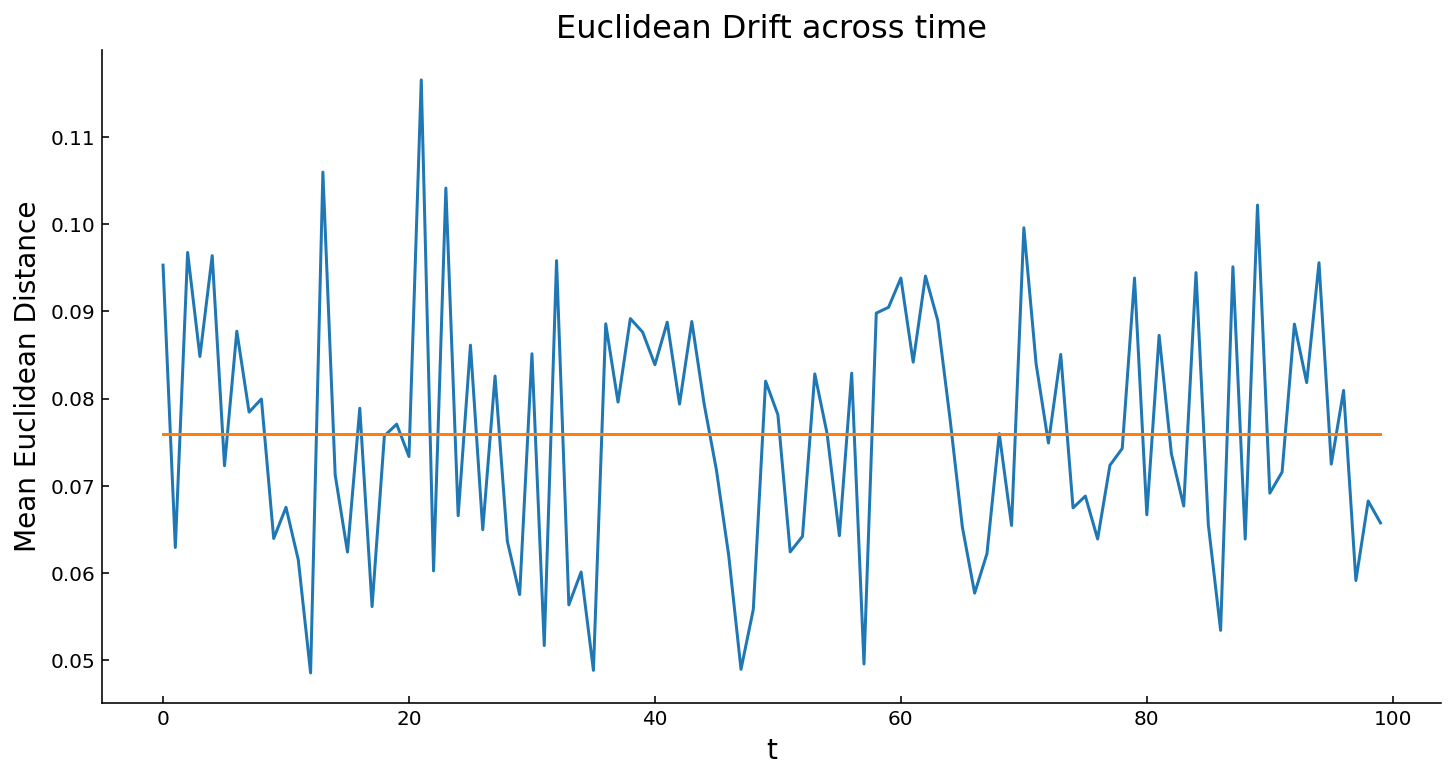

In [81]:
def plot_euclidean_drift(euclidean_dist_stacked):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    stylize_axes(ax)
    ax.plot(euclidean_dist_stacked)
    ax.plot(np.mean(euclidean_dist_stacked)*np.ones(len(euclidean_dist_stacked)))
    
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('Mean Euclidean Distance', fontsize=14)
    plt.title('Euclidean Drift across time', fontsize=16)

    ax.legend(frameon=False)
    plt.show()

plot_euclidean_drift(euclidean_dist_stacked)

## Correlation between Lyapunov Spectra and Peformance

In [82]:
# TODO: Plot the performance correlation for the filter and bptt methods.

# Supplementary Material

## Compare against Target FT

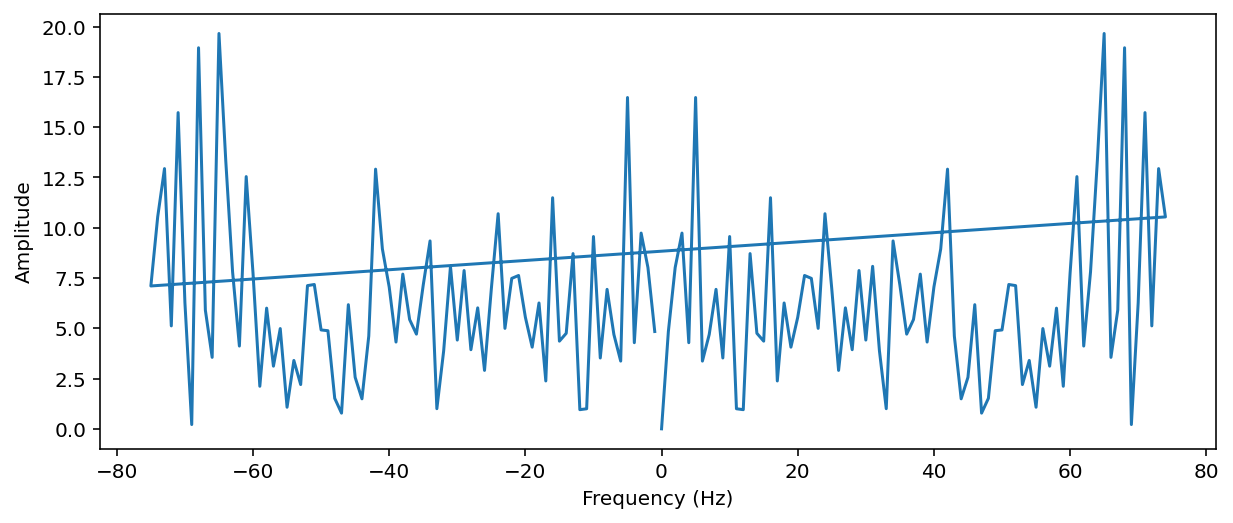

In [83]:
from scipy import fftpack

fft = fftpack.fft(output)

amplitude = abs(fft)
power = amplitude**2
angle = np.angle(fft)

peak_amplitude_index = np.argmax(abs(fft))

sample_freq = fftpack.fftfreq(len(output), d=1/seq_len)
peak_amplitude_freq = sample_freq[peak_amplitude_index]

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(sample_freq, abs(fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

In [84]:
# print(realW_bptt, imagW_bptt)
# print(imagW_bptt[0]/(2*np.pi))